In [6]:
import torch 
from torch import nn

import numpy as np
import math
import matplotlib.pyplot as plt

import pandas as pd

from utils.create_data import *

In [4]:
torch.manual_seed(111)

# Training Data 

In [42]:
trainig_data_length = 1024
train_data = torch.zeros((trainig_data_length,2))
train_data[:,0] = 2*math.pi*torch.rand(trainig_data_length)
train_data[:,1] = torch.sin(train_data[:,0])
train_labels = torch.zeros(trainig_data_length)
#tensor labels just bcz required by pytorch data loader but not used bcz gans use unsupervised learning techniques
train_set = [
    (train_data[i], train_labels[i]) for i in range(trainig_data_length)
]

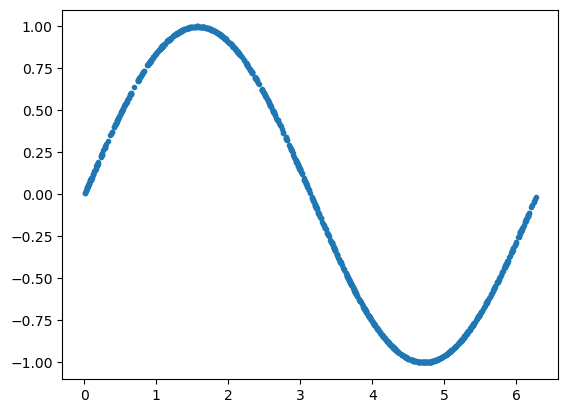

In [43]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [44]:
#Pytorch data loader
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

# Discriminator

In [45]:
#takes as an entry the real/fake data and returns the probability of the input being real
#dim of entry is 2, dim of output is 1
class Discriminator(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3), #zeroes 30 percent of the input layer to prevent overfitting
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        output = self.model(x)
        return output


In [46]:
discriminator = Discriminator()

# Generator

In [47]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2), # a vector of 2 elements and no activation function so it can range from -inf to inf 
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [48]:
generator = Generator()

# Training the Models

In [49]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [50]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [51]:
print(train_loader)

In [52]:
for epoch in range(num_epochs):
    #each batch is a tuple (real_samples, labels) where real_samples is a tensor of batch_size (32) data
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.21308740973472595
Epoch: 0 Loss G.: 1.7989581823349


Epoch: 10 Loss D.: 0.6099680662155151
Epoch: 10 Loss G.: 0.9077385067939758
Epoch: 20 Loss D.: 0.6200631260871887
Epoch: 20 Loss G.: 0.9532093405723572
Epoch: 30 Loss D.: 0.6283484697341919
Epoch: 30 Loss G.: 0.9910151362419128
Epoch: 40 Loss D.: 0.6843723058700562
Epoch: 40 Loss G.: 0.6606213450431824
Epoch: 50 Loss D.: 0.6624276638031006
Epoch: 50 Loss G.: 0.7260463237762451
Epoch: 60 Loss D.: 0.7013164162635803
Epoch: 60 Loss G.: 0.663277268409729
Epoch: 70 Loss D.: 0.6673065423965454
Epoch: 70 Loss G.: 0.7007033228874207
Epoch: 80 Loss D.: 0.6546181440353394
Epoch: 80 Loss G.: 0.7684346437454224
Epoch: 90 Loss D.: 0.7291876077651978
Epoch: 90 Loss G.: 0.6766138076782227
Epoch: 100 Loss D.: 0.6198608875274658
Epoch: 100 Loss G.: 0.8269668817520142
Epoch: 110 Loss D.: 0.6426212787628174
Epoch: 110 Loss G.: 0.7759957909584045
Epoch: 120 Loss D.: 0.6716338992118835
Epoch: 120 Loss G.: 0.7812103629112244
Epoch: 130 Loss D.: 0.6578238010406494
Epoch: 130 Loss G.: 0.8778160214424133
Epoch

In [53]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

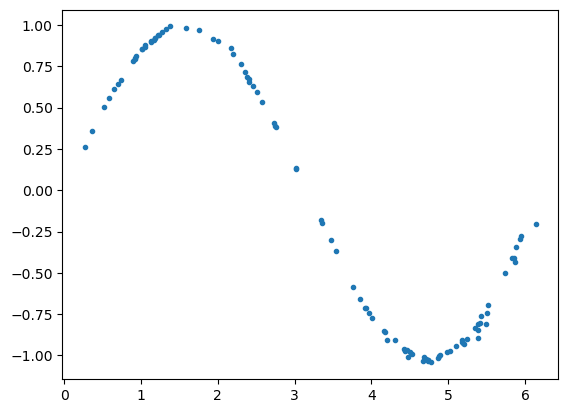

In [54]:
generated_samples = generated_samples.detach()
#since the generator gives a 2 elemts vector and we pass through it 100 elements, the size of generated_samples is 100x2
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

# MNIST Example

In [55]:
import torchvision
import torchvision.transforms as transforms

In [56]:
#device object to move the data and the models to the GPU if there is any
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [57]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [33]:
train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)

NameError: name 'torchvision' is not defined

In [59]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

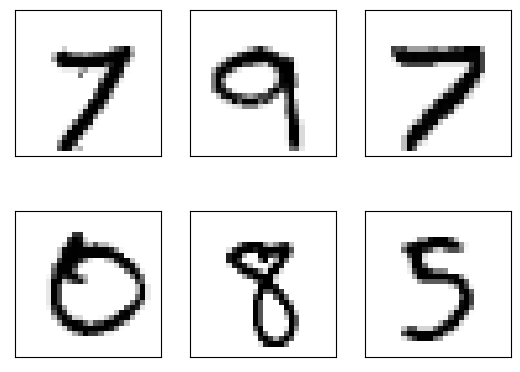

In [69]:
# dim (batch_size, num_channels, heigh, width)
real_samples, mnist_labels = next(iter(train_loader))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
                #dim (1, 28, 28) -> dim (28, 28)
    plt.imshow(real_samples[i].reshape(28,28), cmap = "gray_r")
    #to remove the numbers on axis
    plt.xticks([])
    plt.yticks([])

In [78]:
#adapting the discriminator to the MNIST dataset
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784,1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        #tensor from dim (batch_size, 1, 28, 28) to dim (batch_size, 784)
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
    
#to run the discriminator on the GPU
discriminator = Discriminator().to(device=device)    

In [79]:
class Generator(nn.Module):
    def __init__(self): 
        super().__init__()
        self.model = nn.Sequential(
            #100 dimension of the latent space bcz we want more complex data
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            #to have an output between -1 and 1 bcz the data is normalized
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        #to have the output in the same format as the input of the discriminator
        output = output.view(x.size(0), 1, 28, 28)
        return output
    
generator = Generator().to(device=device)

In [80]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)   

In [81]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5417038202285767
Epoch: 0 Loss G.: 0.5163935422897339
Epoch: 1 Loss D.: 0.05412479490041733
Epoch: 1 Loss G.: 4.674136638641357
Epoch: 2 Loss D.: 0.10477016121149063
Epoch: 2 Loss G.: 7.522878646850586
Epoch: 3 Loss D.: 0.09657073765993118
Epoch: 3 Loss G.: 2.92791748046875
Epoch: 4 Loss D.: 0.12099998444318771
Epoch: 4 Loss G.: 3.9631431102752686
Epoch: 5 Loss D.: 0.11893763393163681
Epoch: 5 Loss G.: 3.4350359439849854
Epoch: 6 Loss D.: 0.01703747734427452
Epoch: 6 Loss G.: 4.692300796508789
Epoch: 7 Loss D.: 0.1227843314409256
Epoch: 7 Loss G.: 4.184162616729736
Epoch: 8 Loss D.: 0.18754945695400238
Epoch: 8 Loss G.: 4.262258052825928
Epoch: 9 Loss D.: 0.013656873255968094
Epoch: 9 Loss G.: 7.787781715393066
Epoch: 10 Loss D.: 0.23655694723129272
Epoch: 10 Loss G.: 2.1049232482910156
Epoch: 11 Loss D.: 0.23686571419239044
Epoch: 11 Loss G.: 3.6072895526885986
Epoch: 12 Loss D.: 0.265701025724411
Epoch: 12 Loss G.: 1.9744330644607544
Epoch: 13 Loss D.: 0.458606719

In [82]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

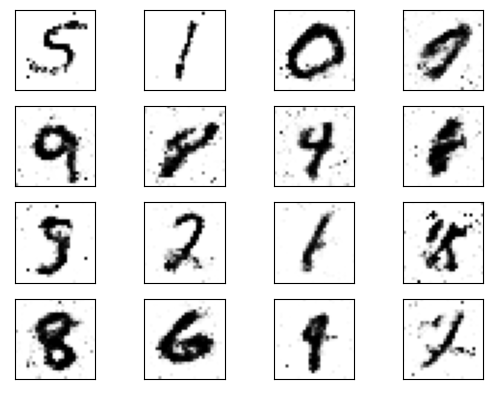

In [83]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

# Gan basique sur les vrais Données 

In [ ]:
df = pd.read_csv('./data/GANData.csv')
asset = "UK Government Bond - USD Hedged"
price = df[df['ASSETNAME']==asset]['PRICE']
y = np.log(price/price.shift(1))[1:].to_numpy()
true_y = price.to_numpy()

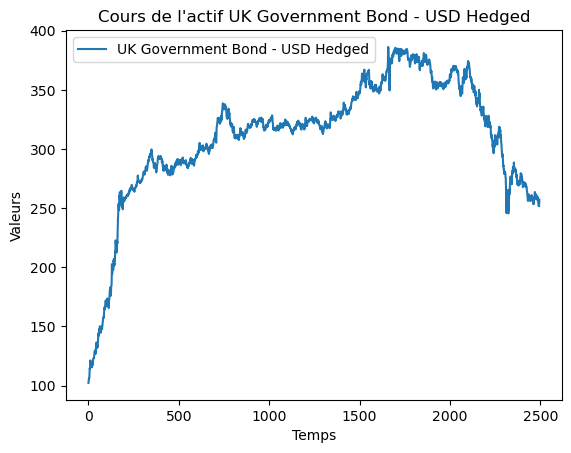

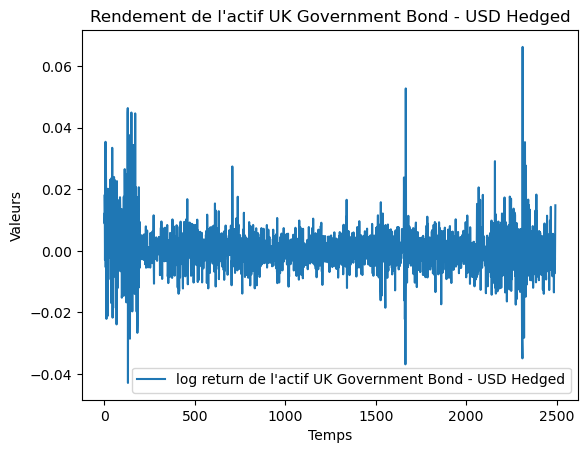

In [ ]:
easy_plot(true_y,f"Cours de l'actif {asset}", f"{asset}")
easy_plot(y,f"Rendement de l'actif {asset}", f"log return de l'actif {asset}")

In [ ]:
trainin_data_length = len(y)
train_data = torch.zeros((trainin_data_length,2))
train_data[:,0] = torch.arange(trainin_data_length)
train_data[:,1] = torch.from_numpy(y)
train_labels = torch.zeros(trainin_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(trainin_data_length)
]

In [ ]:
print(trainin_data_length)

2494


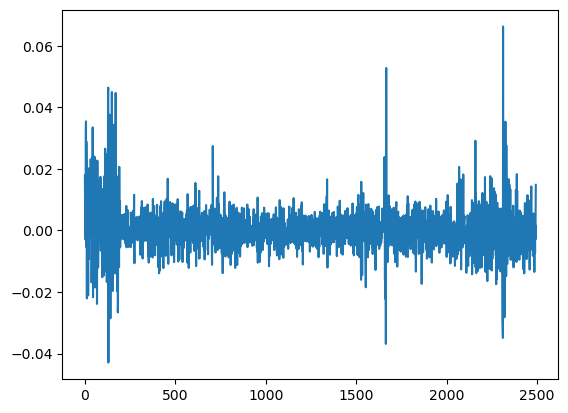

In [ ]:
plt.plot(train_data[:, 0], train_data[:, 1])

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True
)

In [ ]:
class Discriminator(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3), #zeroes 30 percent of the input layer to prevent overfitting
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        output = self.model(x)
        return output 

In [ ]:
discriminator = Discriminator()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2), 
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
generator = Generator()

In [ ]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    #each batch is a tuple (real_samples, labels) where real_samples is a tensor of batch_size (32) data
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6249749660491943
Epoch: 0 Loss G.: 1.8476409912109375
Epoch: 10 Loss D.: 0.0007969530415721238
Epoch: 10 Loss G.: 7.566478729248047
Epoch: 20 Loss D.: 0.14534425735473633
Epoch: 20 Loss G.: 8.092247009277344
Epoch: 30 Loss D.: 0.0006174065638333559
Epoch: 30 Loss G.: 7.162257194519043
Epoch: 40 Loss D.: 0.0003286484570708126
Epoch: 40 Loss G.: 8.860541343688965
Epoch: 50 Loss D.: 0.00021325101261027157
Epoch: 50 Loss G.: 11.57223892211914
Epoch: 60 Loss D.: 0.0006299098022282124
Epoch: 60 Loss G.: 8.125173568725586
Epoch: 70 Loss D.: 0.00028462105547077954
Epoch: 70 Loss G.: 8.531076431274414
Epoch: 80 Loss D.: 0.0005876634968444705
Epoch: 80 Loss G.: 8.782150268554688
Epoch: 90 Loss D.: 0.0005933553329668939
Epoch: 90 Loss G.: 7.721450328826904
Epoch: 100 Loss D.: 9.525928180664778e-05
Epoch: 100 Loss G.: 10.077516555786133
Epoch: 110 Loss D.: 0.0001195916993310675
Epoch: 110 Loss G.: 9.1959810256958
Epoch: 120 Loss D.: 0.0005351450527086854
Epoch: 120 Loss G.: 8.1